In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from functions.checks_and_preprocessing.lagging_and_splitting import split_dataframe, sliding_window
from functions.models.models_and_training import create_multiple_LSTM, train_model
from functions.data_load_and_transform.sql_connections import get_database_connector, get_beach_data
from functions.plotting.forecast_plot import plot_forecast
from sklearn.preprocessing import MinMaxScaler, StandardScaler


Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. 
You can still standardize your time series data if this expectation is not met, but you may not get reliable results.
Make histogram to check if standartization or normalization should be done

In [2]:
single_beach_data, beach_name_sql_table = get_beach_data(get_database_connector())


Selected Beach Details:
силистар


In [92]:
single_beach_data_w = single_beach_data.resample("W").mean()
column_names = list(single_beach_data_w.columns)

In [67]:
train, valid, test, test_index = split_dataframe(single_beach_data_w)
features = len(single_beach_data_w.columns)

def scale_data(train: np.ndarray, valid: np.ndarray, test: np.ndarray, scaler_type: str) -> tuple:
    """
    Function to scale data using either MinMaxScaler or StandardScaler.

    Parameters:
    train (np.ndarray): Training data to be scaled.
    valid (np.ndarray): Validation data to be scaled.
    test (np.ndarray): Test data to be scaled.
    scaler_type (str): Type of scaler to use. Choose either 'minmax' or 'standard'.

    Returns:
    tuple: Scaled training, validation and test data as numpy np.ndarray, and the fitted scaler.
    """
    
    if scaler_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        return "Invalid scaler type. Choose either 'minmax' or 'standard'."

    train_scaled = scaler.fit_transform(train)
    valid_scaled = scaler.transform(valid)
    test_scaled = scaler.transform(test)

    return train_scaled, valid_scaled, test_scaled, scaler 

In [69]:
train_scaled, valid_scaled, test_scaled, scaler = scale_data(train, valid, test, 'minmax')
#train_scaled, valid_scaled, test_scaled = scale_data(train, valid, test, 'standard')

In [6]:
window_size = 1

trainX, trainY = sliding_window(train_scaled, window_size)
valX, valY = sliding_window(valid_scaled, window_size)
testX, testY = sliding_window(test_scaled, window_size)

In [ ]:
#make baseline model

In [15]:
def generate_models(layers: list, units: list, window: int = window_size, features: int = features) -> dict:
    models = {}

    for n_layers in layers:
        for n_units in units:
            K.clear_session()

            model_name = f'{n_layers} layers, {n_units} units'
            model = create_multiple_LSTM(n_layers=n_layers, units=n_units, window=window, features=features)
            models[model_name] = {
                'model': model,
                'history': None
            }



            print(f"Summary of the model: {model_name}")
            model.summary()
            print("\n")  

    return models

In [23]:
layers = [1, 2]
units = [1, 10, 100, 1000, 2000]

models = generate_models(layers=layers, units=units, window=window_size, features=features)

Summary of the model: 1 layers, 1 units
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 84        
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 19)                627       
                                                                 
Total params: 775 (3.03 KB)
Trainable params: 775 (3.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Summary of the model: 1 layers, 10 units
Model: "sequential"
_______________________________________________________

In [24]:
for model_info in models.values():
    model_info['history'] = train_model(model=model_info['model'], trainX=trainX, trainY=trainY, valX=valX, valY=valY, patience=20)

Epoch 1/500
98/98 [==============================] - 1s 3ms/step - loss: 0.0836 - root_mean_squared_error: 0.2891 - mean_absolute_error: 0.2286 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600 - val_mean_absolute_error: 0.1257
Epoch 2/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0248 - root_mean_squared_error: 0.1576 - mean_absolute_error: 0.1219 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1500 - val_mean_absolute_error: 0.1168
Epoch 3/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - mean_absolute_error: 0.1182 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475 - val_mean_absolute_error: 0.1151
Epoch 4/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - mean_absolute_error: 0.1169 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1465 - val_mean_absolute_error: 0.1144
Epoch 5/500
98/98 [==============================] - 0s 1ms/

In [54]:
def get_best_model(models: dict, metric: str = 'root_mean_squared_error') -> dict:
    best_model_name = None
    best_model_history = None
    best_metric_value = float('inf')

    # Prepare a list to store model names and their metric values
    model_metrics = []

    for model_name, model_info in models.items():
        if model_info['history'] is not None:
            # Get the metrics for the current model
            rmse = model_info['history'].history['root_mean_squared_error'][-1]
            mae = model_info['history'].history['mean_absolute_error'][-1]
            val_rmse = model_info['history'].history['val_root_mean_squared_error'][-1]
            val_mae = model_info['history'].history['val_mean_absolute_error'][-1]

            # Append the model name and its metrics to the list
            model_metrics.append((model_name, rmse, mae, val_rmse, val_mae))

            # Find the best value for the specified metric
            metric_values = model_info['history'].history[metric]
            min_metric_value = min(metric_values)
            if min_metric_value < best_metric_value:
                best_metric_value = min_metric_value
                best_model_name = model_name
                best_model_history = model_info['history']

    # Print a table of all models and their metrics
    print(f"{'Model Name':<20} {'RMSE':<10} {'MAE':<10} {'Val RMSE':<10} {'Val MAE':<10}")
    for name, rmse, mae, val_rmse, val_mae in model_metrics:
        indicator = '*' if name == best_model_name else ''  # Add a star next to the best model
        print(f"{name:<20} {rmse:<10.4f} {mae:<10.4f} {val_rmse:<10.4f} {val_mae:<10.4f} {indicator}")

    return {best_model_name: best_model_history}

In [55]:
best_model = get_best_model(models, 'root_mean_squared_error')

Model Name           RMSE       MAE        Val RMSE   Val MAE   
1 layers, 1 units    0.1465     0.1132     0.1438     0.1120     
1 layers, 10 units   0.1443     0.1113     0.1425     0.1101     
1 layers, 100 units  0.1434     0.1106     0.1428     0.1105     
1 layers, 1000 units 0.1436     0.1107     0.1433     0.1110     
1 layers, 2000 units 0.1444     0.1113     0.1432     0.1108     
2 layers, 1 units    0.1462     0.1129     0.1438     0.1117     
2 layers, 10 units   0.1448     0.1117     0.1419     0.1100     
2 layers, 100 units  0.1441     0.1111     0.1424     0.1107     
2 layers, 1000 units 0.1423     0.1095     0.1442     0.1119     
2 layers, 2000 units 0.1420     0.1094     0.1448     0.1123     *


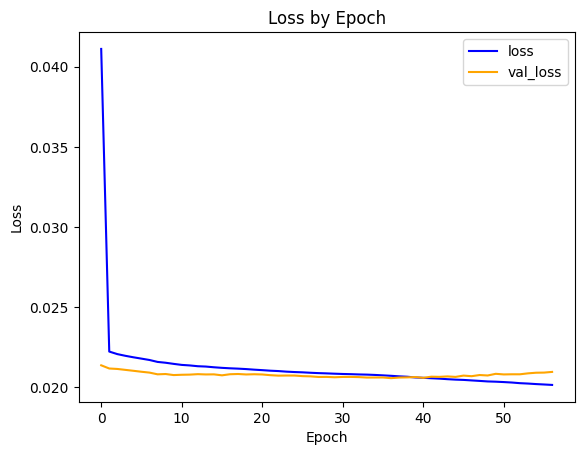

In [56]:
plot_forecast(best_model)

In [47]:
best_model_name, best_model_info = list(best_model.items())[0]

In [ ]:
#ChatGPT on if I can use multiindex df for LSTM

In [71]:
model_name, _ = list(best_model.items())[0]
trained_model = models[model_name]['model']

# Now you can make predictions
predictions = trained_model.predict(testX)

11/11 [==============================] - 0s 36ms/step


In [73]:
predictions = scaler.inverse_transform(predictions)
testY = scaler.inverse_transform(testY)

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(testY, predictions)

rmse = np.sqrt(mse)
mae = mean_absolute_error(testY, predictions)
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

MSE: 117639629.61962846, RMSE: 10846.180416147818, MAE: 4922.798648144742


In [96]:
def plot_actual_vs_predicted(best_model: dict, X: np.ndarray, Y: np.ndarray, scaler: MinMaxScaler or StandardScaler, column_names: list) -> None:
    """
    Plots the actual and predicted values for each feature in the dataset.

    Parameters:
    best_model (dict): The best model and its history returned by get_best_model.
    X (np.ndarray): The data (either training or validation).
    Y (np.ndarray): The labels (either training or validation).
    scaler (MinMaxScaler or StandardScaler): The scaler used to scale the data.
    column_names (list): The names of the columns (features).

    Returns:
    None
    """

    # Extract the model name and history from the best_model dictionary
    model_name, history = list(best_model.items())[0]

    # Get the predictions on the data
    Predict = history.model.predict(X)

    # Reverse the scaling
    Y = scaler.inverse_transform(Y)
    Predict = scaler.inverse_transform(Predict)

    num_columns = Y.shape[1]

    # Create subplots for each column
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5*num_columns), sharex=True)

    # Loop through each column and plot the actual vs. predicted values
    for col in range(num_columns):
        actual = Y[:, col]
        predicted = Predict[:, col]

        # Plot actual values in blue
        axes[col].plot(actual, label='Actual', color='blue')
        
        # Plot predicted values in orange
        axes[col].plot(predicted, label='Predicted', color='orange')
        
        # Add labels and legends
        axes[col].set_xlabel('Sample')
        axes[col].set_ylabel('Value')
        axes[col].legend()

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()


In [97]:
plot_actual_vs_predicted(best_model, trainX, trainY, 'Train', scaler, column_names)

NameError: name 'scaler_type' is not defined

11/11 [==============================] - 0s 35ms/step


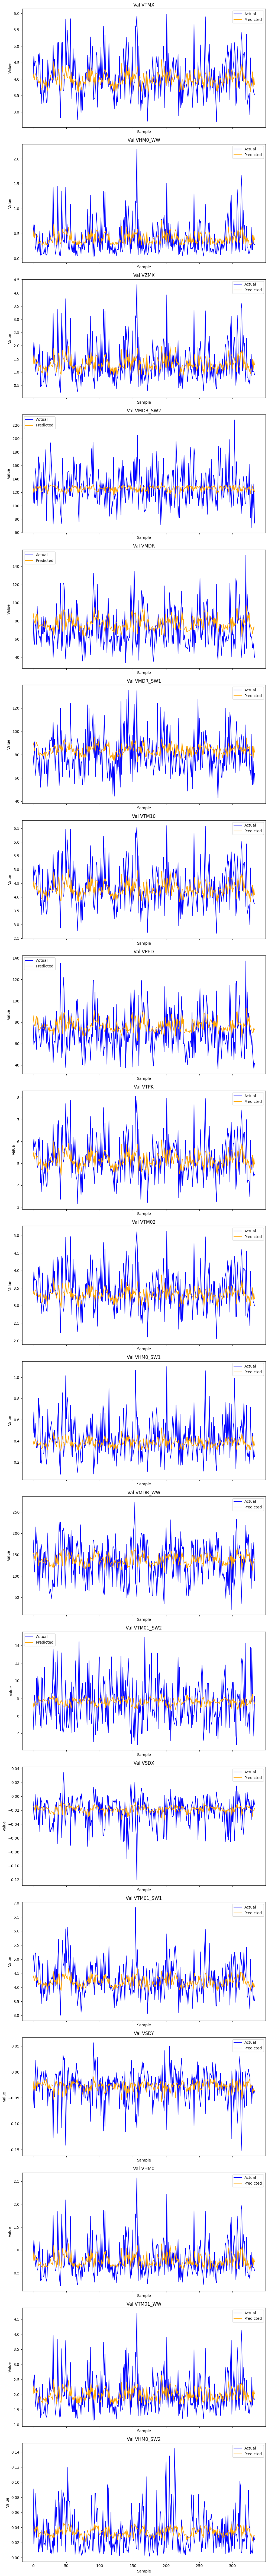

In [88]:
plot_actual_vs_predicted(best_model, valX, valY, 'Val', scaler, column_names)

In [ ]:
#plot the expected value after test set

In [ ]:
#post this line it needs to be changed, due to the multi model change.

In [ ]:
#training loss, validation loss/ training, validation accuracy plot as well

In [ ]:
#batch normalization 

In [ ]:
#Tip: ACF - window size that aligns with these significant lags to capture these patterns of seasonality or temporality 
#Tip2: PACF - how many previous time steps to include in your window

In [ ]:
#only are non-stationary. VMDR and VMDR_WW are measured in degrees, we can do some trigonometry magic. VSDX m/s we can do STL if needed

In [ ]:
#Feature Engineering:

#Lag Features: Create lag features (i.e., features with past values of the target variable) to capture autocorrelation. Experiment with different lag values to see which ones are most informative.